In [7]:
import csv, math
from math import exp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [8]:
def pid_controller(error_hist):

    # parameters
    Kp=0.5
    Ki=1
    tor_i=100
    Kd=0.05
    u_steady = (5/54) * 12 * 15
    
    calc_u = u_steady + Kp * error_hist[-1] + Ki * sum(error_hist) / tor_i + Kd * (error_hist[-1] - error_hist[-2])
    
    if calc_u < 0:
        calc_u=0
    
    return calc_u

In [9]:
# Human Glucose - Insulin System Model by Bergman 1981
# A simple 3 equation model.

# States = [Plasma Glucose(G), 
#           Plasma Insulin Remote Compartment(X), 
#           Plasma Insulin(I)]

def bergman_minmod(x, U, D):

    G=x[0]
    X=x[1]
    I=x[2]
    # Parameters
    Gb=4.5
    Xb=15
    Ib=15
    # For T1D, Some papers P1 = 0 to T1D
    P1=0.028735
    P2=0.028344
    P3=5.035e-05
    V1=12
    n=5 / 54
    # Minimal Model
    Gdt = -P1 * (G - Gb) - (X - Xb) * G + D
    Xdt = -P2 * (X - Xb) + P3 * (I - Ib)
    Idt = -n * I + U / V1
    dx_dt = [Gdt, Xdt, Idt]

    return dx_dt

In [10]:
def meal_profile(t):

    # One meal
    # d = 3 * exp(-0.05 * (t));
    
    #Two meals
    if t < 100:
        d = 0
    elif t >= 100 and t < 500:
        d = 3 * exp(-0.05 * (t-100))
    elif t >= 500 and t < 600:
        d = 0
    elif t >= 600 and t < 1000:
        d = 1 * exp(-0.05 * (t-600))
    else:
        d = 0

    return d

In [5]:
# Run the simulation for Bergman Glucose Model
tend = 1000
tspan = [i for i in range(tend)]

x0 = [4.5, 15, 15]
# glucose_high = 8.3
# glucose_low = 4.4
# g_target = 6

# meal
d = []
for t in range(tspan):
    d.append(meal_profile(t))

t,dx_dt=odeint(lambda t=None,x=None: bergman_minmod(x,u1(x),d(t)),tspan,x0,args=())

x = odeint(bergman_minmod, x0, t, args=(b, c))


In [ ]:
G=x[:, 1]
X=x[:, 2]
I=x[:, 3]

In [ ]:
# visulization
figure
subplot(4,1,1)
plot(t,G)
yline(glucose_high,'-.r')
yline(glucose_low,'-.r')
yline(g_target,'-.g')
legend('Glucose')
xlabel('Time (min)')
ylabel('mmol/L')
title('Glucose')
subplot(4,1,2)
fplot(d,concat([0,tend]))
hold('on')
plot(100,d(100),'kd')
text(110,d(100),'Meal')
hold('on')
plot(600,d(600),'kd')
text(610,d(600),'Snack')
ylim(concat([0,5]))
legend('Meal Model')
xlabel('Lmin')
ylabel('mmol')
title('Meal Profile')
# subplot(4,1,3);
# plot(t,control_action);
# #ylim([0 100])
# legend('Infused Insulin');
# xlabel('min');
# ylabel('mU');
# title('Infused Insulin (U)')
    
subplot(4,1,3)
plot(t,I,t,X)
legend('Plasma Insulin','Remote Compartment Insulin')
xlabel('Time (min)')
ylabel('mU/L')
title('Plasma & Remote Compartment Insulin')
sgtitle('Human Glucose Insulin Model - Bergman Minimal Model (1981) - PID Control')

In [6]:
# Calculate the percentage error between two lists of data
def pe(ls1, ls2):
    if len(ls1) != len(ls2):
        print("Error: the input lists are of different length!")
        return 0
    else:
        n = len(ls1)
        sm = 0
        for i in range(0, n):
            sm += abs((ls1[i]-ls2[i])/ls2[i])*100
        return sm/n

In [ ]:
mean = 10
std = 10
num_samples = 10000
samples = np.random.normal(mean, std, size=num_samples)
pd.DataFrame(samples).to_csv('data/white_noise.csv', index=False, header=False)

In [16]:
samples = pd.read_csv('data/white_noise.csv', header=None)
samples.rename(columns={0: 'value'}, inplace=True)
samples_list = samples['value'].tolist()
samples_list

[-4.7995270924256666,
 18.05721940964936,
 25.351703300556093,
 -4.083530864046228,
 19.753131086649123,
 13.277008179992551,
 1.4618473099948464,
 6.940130940010662,
 25.351153593384023,
 6.7063938729832575,
 11.502516819120602,
 11.542855786237775,
 2.889103726461805,
 -7.759767952086339,
 13.835093790541409,
 7.872674950720918,
 12.323952926600068,
 23.875401479945346,
 -1.6656222059361596,
 12.810363112945813,
 19.54844148070432,
 -1.8603119873151464,
 6.161500425823528,
 17.67796301119632,
 13.471277468190248,
 -2.8697016872436425,
 -2.9104928978627065,
 9.873627143961402,
 22.97401840410409,
 9.990820744437308,
 3.577154137076862,
 -5.0117455340587265,
 15.509983171928663,
 -4.061826259602256,
 5.47675364113636,
 1.9447846565198592,
 9.906943741636967,
 22.720388719716407,
 11.840619382204384,
 16.705900795972322,
 -2.2674782081773235,
 0.0595779517880608,
 -13.866937929598516,
 8.912813983507228,
 23.469414639231893,
 11.496396228027749,
 10.621067050026817,
 10.003184524944487,

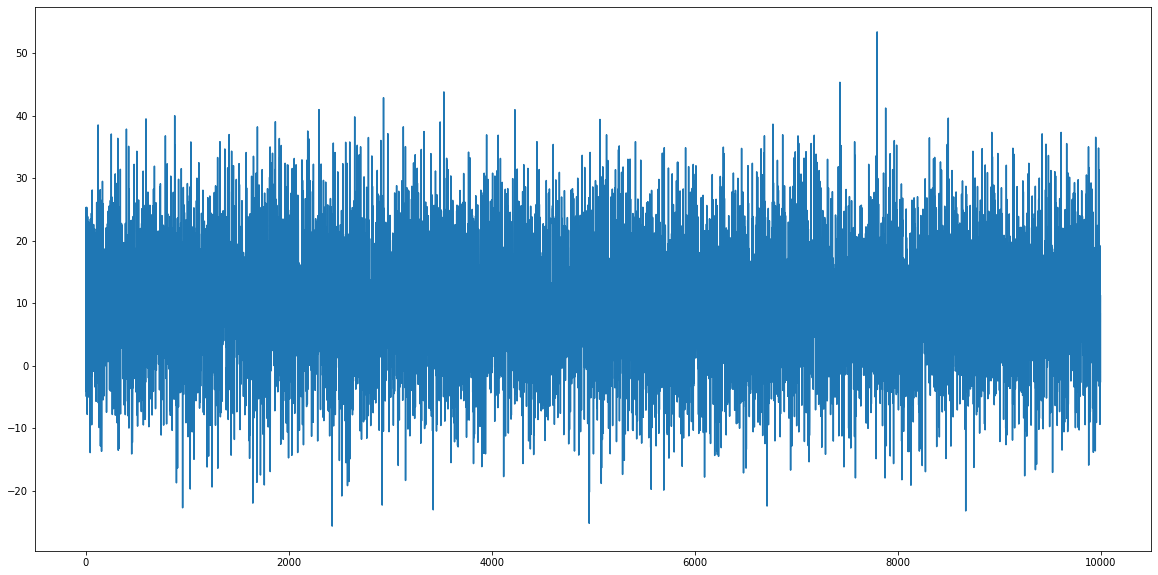

In [17]:
plt.figure(figsize=(20,10))
plt.plot(samples_list)
plt.show()

In [20]:
signal = []
for i in range(2, len(samples_list)):
    tmp = pid_controller(samples_list[:i])
#     if tmp < 0:
#         tmp = 0
    signal.append(tmp)

signal

[26.970690619767336,
 30.093336467667847,
 13.498398173950772,
 28.277855265929826,
 23.656924651533867,
 17.497010791467904,
 21.170226140876593,
 31.275885954664993,
 20.167780914505737,
 23.852911689092522,
 23.75072053156248,
 19.018030987594454,
 13.51624148786091,
 26.064209968138993,
 21.783863268613548,
 24.6534266266041,
 31.0229134469495,
 16.38112176998805,
 25.748068510796667,
 28.925696761926787,
 16.795375316255004,
 22.339424821140486,
 28.44916825255055,
 25.694380849310473,
 16.888479574099705,
 17.653988437052284,
 24.786030292026112,
 31.581779667054423,
 23.88590959867493,
 21.043324388980793,
 16.589995444883655,
 28.461491048452785,
 16.63029116321539,
 22.90986811660954,
 20.509804026598733,
 25.164659410060334,
 32.041150080945336,
 25.5350108902318,
 28.921963142639484,
 18.220665837587006,
 20.449811455293336,
 12.535205533236462,
 25.84952301934902,
 32.951359930734625,
 25.753333734066384,
 25.976764277226344,
 25.780727192580557,
 25.51891204473376,
 15.282

In [21]:
pd.DataFrame(signal).to_csv('data/signal.csv', index=False, header=False)

In [11]:
seal_result = pd.read_csv('data/seal_result.csv', header=None)
seal_result.rename(columns={0: 'value'}, inplace=True)
seal_result

,value
0,24.5146
1,24.5514
2,28.3938
3,14.1520
4,19.2933
...,...
993,127.4300
994,122.6850
995,125.5440
996,116.1920


In [12]:
seal_result_recursive = pd.read_csv('data/seal_result_recursive.csv', header=None)
seal_result_recursive.rename(columns={0: 'value'}, inplace=True)
seal_result_recursive

,value
0,24.5146
1,24.5514
2,28.3938
3,14.1520
4,19.2933
...,...
993,127.4300
994,122.6850
995,125.5440
996,116.1920


In [13]:
seal_result_reencryption = pd.read_csv('data/seal_result_reencryption.csv', header=None)
seal_result_reencryption.rename(columns={0: 'value'}, inplace=True)
seal_result_reencryption

,value
0,24.5146
1,24.5514
2,28.3938
3,14.1520
4,19.2933
...,...
993,127.4300
994,122.6850
995,125.5440
996,116.1920


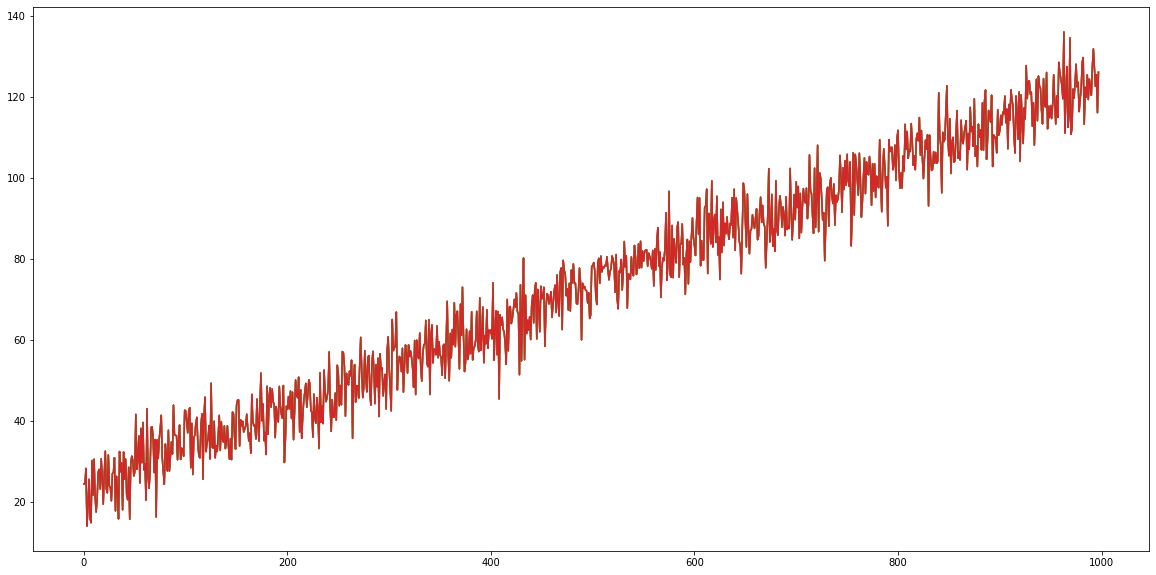

In [14]:
plt.figure(figsize=(20,10))
plt.plot(signal)
plt.plot(seal_result)
plt.plot(seal_result_recursive)
plt.plot(seal_result_reencryption)
plt.show()

In [15]:
seal_result_list = seal_result['value'].tolist()
pid_error = pe(signal, seal_result_list)
seal_result_recursive_list = seal_result_recursive['value'].tolist()
rpid_error = pe(signal, seal_result_recursive_list)
seal_result_reencryption_list = seal_result_reencryption['value'].tolist()
rrpid_error = pe(signal, seal_result_reencryption_list)
print("Error between normal PID and plaintext PID: ", 100*pid_error, "%")
print("Error between recursive PID and plaintext PID: ", 100*rpid_error, "%")
print("Error between recursive PID with re-encryption and plaintext PID: ", 100*rrpid_error, "%")

Error between normal PID and plaintext PID:  0.5640833017713249 %
Error between recursive PID and plaintext PID:  0.5640833017713249 %
Error between recursive PID with re-encryption and plaintext PID:  0.5640833017713249 %
